In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, datasets, utils

import os
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

# for practice
import re
import shutil

In [2]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

In [3]:
# load image files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
## image file들을 읽어서 channel이 3이 아닌 image는 삭제
## directory 설정
cur_dir = os.path.abspath('/content/drive/Shareddrives/aircraft/sample_image_files')
image_dir = os.path.join(cur_dir, '224resized')
image_files = [fname for fname in os.listdir(image_dir) if os.path.splitext(fname)[-1] == '.jpg']
corrupt_files = ['Egyptian_Mau_156', 'chihuahua_121', 'beagle_116']
"""
for image_file in image_files:
  image_path = os.path.join(image_dir, image_file)
  image = Image.open(image_path)
  image_mode = image.mode
  if image_mode != 'RGB':
    print(image_file, image_mode)
    image = np.asarray(image)
    print(image.shape)
    os.remove(image_path)
  name, ext = os.path.splitext(image_file)
  for corrupt_file in corrupt_files:
    if name == corrupt_file:
      file_path = os.path.join(image_dir, image_file)
      print(file_path)
      os.remove(file_path)
    else:
      pass
"""

"\nfor image_file in image_files:\n  image_path = os.path.join(image_dir, image_file)\n  image = Image.open(image_path)\n  image_mode = image.mode\n  if image_mode != 'RGB':\n    print(image_file, image_mode)\n    image = np.asarray(image)\n    print(image.shape)\n    os.remove(image_path)\n  name, ext = os.path.splitext(image_file)\n  for corrupt_file in corrupt_files:\n    if name == corrupt_file:\n      file_path = os.path.join(image_dir, image_file)\n      print(file_path)\n      os.remove(file_path)\n    else:\n      pass\n"

In [5]:
# labeling

# 요건 practice 용
image_files = [fname for fname in os.listdir(image_dir) 
              if os.path.splitext(fname)[-1] == '.jpg']
labels = set()
for image_file in image_files:
    file_name = os.path.splitext(image_file)[0]
    class_name = re.sub('_\d+', '', file_name)
    labels.add(class_name)
labels = list(labels)
print(labels)

"""
요건 우리 할 것
labels = ['j10','j11','j15','j16','j20','j31','JL10','j6',
          'y8g','y9jb','y20','kj2000','bjk005','ch3','wingloong',
          'xianglong','z9','z18','mig31','su24','su27','su30',
          'su35','su57','tu95ms','tu142','a50','il38','il20',
          'f2','e767','ec1','ch47j','p1','f4','f5','fa50','f15',
          'f16','fa18','f22','f35','a10','b1','b2','c130','p3',
          'p8','rc135','e737','kc330','u2v']
"""
img_size = 224

['pomeranian', 'havanese', 'Ragdoll', 'saint_bernard', 'newfoundland', 'Persian', 'leonberger', 'Maine_Coon', 'Bengal', 'miniature_pinscher', 'Russian_Blue', 'Egyptian_Mau', 'boxer', 'great_pyrenees', 'japanese_chin', 'shiba_inu', 'Birman', 'Abyssinian', 'american_pit_bull_terrier', 'Sphynx', 'english_setter', 'Siamese', 'scottish_terrier', 'Bombay', 'staffordshire_bull_terrier', 'wheaten_terrier', 'american_bulldog', 'samoyed', 'yorkshire_terrier', 'chihuahua', 'British_Shorthair', 'basset_hound', 'keeshond', 'beagle', 'pug', 'english_cocker_spaniel', 'german_shorthaired']


In [6]:
## Experiment directory setting

train_dir = os.path.join(cur_dir, 'train_dir')
test_dir = os.path.join(cur_dir, 'test_dir')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

for label in labels:
  label_dir = os.path.join(train_dir, label)
  os.makedirs(label_dir, exist_ok=True)
  label_dir = os.path.join(test_dir, label)
  os.makedirs(label_dir, exist_ok=True)

In [7]:
# practice file separate
cnt = 0
previous_class = ""
image_files.sort()

for image_file in image_files:
  file_name = os.path.splitext(image_file)[0]
  class_name = re.sub('_\d+', '', file_name)
  if class_name == previous_class:
    cnt += 1
  else:
    cnt = 1
  if cnt <= 130:
    for label in labels:
        if label == class_name:
          cpath = os.path.join(train_dir, label)
          image_path = os.path.join(image_dir, image_file)
          shutil.copy(image_path, cpath)
        else:
          pass
  else:
    for label in labels:
        if label == class_name:
          cpath = os.path.join(test_dir, label)
          image_path = os.path.join(image_dir, image_file)
          shutil.copy(image_path, cpath)
        else:
          pass
  previous_class = class_name

In [18]:
# Data load and transform
transform1 = transforms.Compose([
                                transforms.RandomCrop(224),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,0.5,0.5),
                                                     (0.5,0.5,0.5))
])
transform2 = transforms.Compose([
                                transforms.RandomCrop(32, padding=4),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,0.5,0.5),
                                                     (0.5,0.5,0.5))
])
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform1)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform1)

# Hyperparameter

"""
추가로 실험해봐야 할 부분
1. epoch / batch size / lr / stepsize 조정
2. crop 조정
"""

EPOCHS = 200       # 40, 150, 300
BATCH_SIZE = 32   # 16, 64, 128

train_loader = torch.utils.data.DataLoader(
    dataset = train_dataset,
    batch_size = BATCH_SIZE
)
test_loader = torch.utils.data.DataLoader(
    dataset = test_dataset,
    batch_size = BATCH_SIZE
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


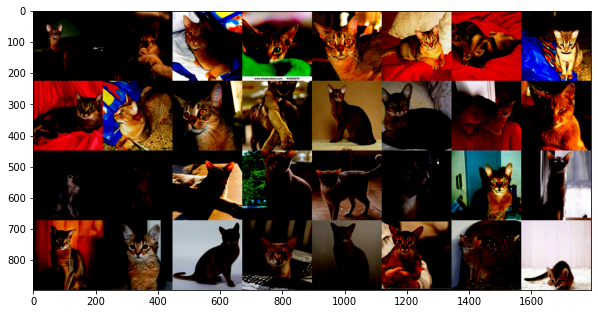

In [19]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
img = utils.make_grid(images, padding=0)
npimg = img.numpy()
plt.figure(figsize = (10,7))
plt.imshow(np.transpose(npimg,(1,2,0)))
plt.show()

In [20]:
print(len(labels))
"""
다른 데이터셋으로 실험 시 반드시 num_classes를 label의 수로 변경
"""

32


'\n다른 데이터셋으로 실험 시 반드시 num_classes를 label의 수로 변경\n'

In [28]:
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, num_classes=37):
        super(ResNet, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(16, 2, stride=1)
        self.layer2 = self._make_layer(32, 2, stride=2)
        self.layer3 = self._make_layer(64, 2, stride=2)
        self.linear = nn.Linear(64*49, num_classes)

    def _make_layer(self, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(BasicBlock(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [29]:
model = ResNet().to(DEVICE)
optimizer = optim.SGD(model.parameters(), lr=0.1,
                      momentum=0.9, weight_decay=0.0005)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

In [30]:
print(model)

ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=

In [31]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

In [32]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)

            # 배치 오차를 합산
            test_loss += F.cross_entropy(output, target,
                                         reduction='sum').item()

            # 가장 높은 값을 가진 인덱스가 바로 예측값
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [33]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
for epoch in range(1, EPOCHS + 1):
    scheduler.step()
    train(model, train_loader, optimizer, epoch)
    test_loss, test_accuracy = evaluate(model, test_loader)
    
    print('[{}] Test Loss: {:.4f}, Accuracy: {:.2f}%'.format(
          epoch, test_loss, test_accuracy))

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


[1] Test Loss: 4.0609, Accuracy: 2.68%
[2] Test Loss: 4.0849, Accuracy: 2.72%
[3] Test Loss: 4.0870, Accuracy: 2.72%
[4] Test Loss: 4.0869, Accuracy: 2.72%
[5] Test Loss: 4.0869, Accuracy: 2.72%
